In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
import re , os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplot
from ColumnMatch import MatchVariable

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [4]:
import os
os.path.abspath("./../../../Data/")

'/home/advice/Python/SR/Data'

In [5]:
data = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-train-0.2-0.0.csv")
in_var = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
          "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
          "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_var = ['default payment next month']
fac_var = [ 'SEX','EDUCATION','MARRIAGE',]
num_var = [i for i in in_var if not i in fac_var]
#in_var = num_var + fac_var
data[fac_var] = data[fac_var].astype("category")

In [6]:
cat_col = data.select_dtypes("category").columns.tolist()
onehot_data = pd.get_dummies(data , columns= cat_col)

In [7]:
select_var = in_var + target_var + ["sep_idx"]
data = data[select_var]

In [8]:
train = data[data.sep_idx ==1 ]
valid = data[data.sep_idx ==0 ]
_ = train.pop("sep_idx")
_ = valid.pop("sep_idx")

In [9]:
Train_X = pd.get_dummies(train , columns= cat_col)
Train_y = Train_X.pop(target_var[0])

In [10]:
num_var = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [11]:
one_hot_var = Train_X.columns.tolist()
#in_var = data.columns.tolist()

In [12]:
MV = MatchVariable()
in_var = MV.match_invar(one_hot_var , in_var)

In [13]:
key_onehot_store , onehot_store = MV.OneHotIndex(in_var , num_var , one_hot_var)

In [14]:
#key_onehot_store , onehot_store = OneHotIndex(in_var , num_var , one_hot_var)

In [15]:
test = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-test-0.2-0.0.csv")
Test_y = test.pop(target_var[0])
Test_X = pd.get_dummies(test , columns= fac_var)[one_hot_var]

In [16]:
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [17]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler

numeric_features = num_var
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('scaler2', MinMaxScaler(feature_range=(-1,1)))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])
clf = Pipeline(steps=[('preprocessor', preprocessor),])

In [19]:
clf.fit(Train_X)
Train_X[num_var] = clf.transform(Train_X)
Test_X[num_var] = clf.transform(Test_X)

In [20]:
Train_X[num_var].describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000,21018.000000
mean,-0.682829,-0.464902,-0.602925,-0.584080,-0.634142,-0.643974,-0.652306,-0.617542,-0.616212,-0.843085,-0.596590,-0.513785,-0.758775,-0.441184,-0.977627,-0.988815,-0.979883,-0.975954,-0.975658,-0.979912
std,0.261871,0.304673,0.200752,0.236843,0.215053,0.210186,0.201708,0.229504,0.116821,0.126500,0.122235,0.130944,0.108722,0.156250,0.058224,0.032573,0.057007,0.064662,0.068661,0.063035
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.919192,-0.703704,-0.602925,-0.777778,-0.800000,-0.800000,-0.800000,-0.777778,-0.694879,-0.928608,-0.677603,-0.599542,-0.829762,-0.545490,-0.994851,-0.997657,-0.996537,-0.997110,-0.996908,-0.998108
50%,-0.737374,-0.464902,-0.600000,-0.555556,-0.600000,-0.600000,-0.600000,-0.555556,-0.631570,-0.861943,-0.618323,-0.542094,-0.781518,-0.472475,-0.987457,-0.994126,-0.989082,-0.987834,-0.987123,-0.990845
75%,-0.535354,-0.333333,-0.600000,-0.555556,-0.600000,-0.600000,-0.600000,-0.555556,-0.616212,-0.842906,-0.594776,-0.513785,-0.758775,-0.441184,-0.977627,-0.988815,-0.979883,-0.975954,-0.975658,-0.979912
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 앙상블 테스트

In [21]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values

In [22]:
def tf_mish(x, name="mish") :
    act = x * tf.nn.tanh(tf.nn.softplus(x))
    act = tf.identity(act , name)
    return act

In [87]:
row , dim = Train_X_np.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim])
y = tf.placeholder(tf.float32, shape = [ None , 1])
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")

21018 33


In [88]:
def variable_select(in_var = None , method = None , select_n = None , NTree = None) :
    var_n = len(in_var)
    if method== "sqrt" :
        value =np.sqrt(var_n)
    elif method == "log2" :
        value =np.log2(var_n)
    elif method == "select" :
        value = select_n
    else :
        value = var_n
    return [list(np.random.choice(in_var ,
                                  replace = False , 
                                  size = value)) for _ in range(NTree)]
SELECT_N = 5
select_var = variable_select(in_var=in_var , method="select" , 
                               select_n= 15 , NTree= SELECT_N)

In [89]:
print(select_var)

[['BILL_AMT3', 'BILL_AMT2', 'PAY_AMT1', 'BILL_AMT1', 'BILL_AMT6', 'PAY_3', 'PAY_AMT4', 'BILL_AMT5', 'LIMIT_BAL', 'MARRIAGE', 'PAY_5', 'PAY_2', 'PAY_AMT6', 'BILL_AMT4', 'PAY_0'], ['PAY_5', 'PAY_3', 'EDUCATION', 'BILL_AMT1', 'BILL_AMT4', 'LIMIT_BAL', 'BILL_AMT5', 'PAY_2', 'SEX', 'PAY_4', 'PAY_AMT4', 'PAY_AMT5', 'MARRIAGE', 'BILL_AMT3', 'AGE'], ['PAY_AMT3', 'BILL_AMT5', 'PAY_AMT6', 'LIMIT_BAL', 'PAY_5', 'PAY_AMT1', 'PAY_AMT5', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT6', 'BILL_AMT1', 'PAY_4', 'PAY_AMT4', 'PAY_6'], ['PAY_AMT1', 'EDUCATION', 'PAY_0', 'PAY_5', 'PAY_3', 'PAY_4', 'PAY_AMT3', 'AGE', 'PAY_2', 'PAY_AMT6', 'PAY_AMT5', 'SEX', 'BILL_AMT2', 'PAY_6', 'PAY_AMT4'], ['BILL_AMT6', 'BILL_AMT1', 'LIMIT_BAL', 'PAY_5', 'BILL_AMT2', 'PAY_AMT6', 'PAY_AMT5', 'MARRIAGE', 'PAY_2', 'PAY_3', 'PAY_6', 'BILL_AMT4', 'BILL_AMT3', 'AGE', 'PAY_AMT4']]


In [90]:
var = select_var[0]
x_input = []
for key in var :
    start_node , terminal_node = key_onehot_store[key]
    diff = terminal_node - start_node
    X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
    x_input.append(X_Split)

In [91]:
tf.argmax(x_input[0] , axis = 1 )

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [92]:
def Classifier_V2(X , hidden = [[],[]], Nensemble = select_var ) :
    Ensembles = []
    with tf.variable_scope("Ensembles"):
        for idx , __vars__ in enumerate(Nensemble) :
            x_input = []
            for key in __vars__ :
                start_node , terminal_node = key_onehot_store[key]
                diff = terminal_node - start_node
                X_Split = tf.slice(X , [0, start_node] , [-1 , diff])
                if diff > 4 : 
                    embeddings = tf.Variable(tf.truncated_normal([diff, int(diff/2)], 
                                                         stddev = 2/diff ))       
                    X_Split = tf.argmax(X_Split , axis = 1)
                    X_Split = tf.nn.embedding_lookup(embeddings, X_Split)
                x_input.append(X_Split)
            x_input = tf.concat(x_input , axis = 1)
            TOTAL_DIM = x_input.get_shape().as_list()[1]
            SELECT = np.random.randint(0 , len(activate_candidate) , 1)[0]
            activation = activate_candidate[SELECT]
            dims = hidden[idx]
            dims = [TOTAL_DIM] + dims
            print(dims)
            for idx2 , h_dim in enumerate(dims) :
                if idx2 == 0 :
                    Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                                                name=f"W_{idx}{idx2}",
                                                type='xavier_normal', regularize=True)
                    Bias = tf.get_variable(f"Bias_{idx}{idx2}",
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = tf.matmul( x_input , Weight) + Bias
                    if activation != tf.nn.selu :
                        Layer = tf.nn.dropout(Layer , DropoutRate ) 
                    Layer = activation(Layer)
                    if activation == tf.nn.selu :
                        Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
                else :
                    Weight =get_weight_variable(shape = [dims[idx2-1] ,h_dim ], 
                                                name=f"W_{idx}{idx2}",
                                                type='xavier_normal', regularize=True)
                    Bias = tf.get_variable(f"Bias_{idx}{idx2}",
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                    Layer = tf.matmul( Layer , Weight) + Bias
                    if len(dims) == idx2+1 : 
                        pass
                    else : 
                        Layer = activation(Layer)
                        Layer = tf.contrib.nn.alpha_dropout(Layer , DropoutRate ) 
            Ensembles.append(Layer)
        return Ensembles

In [93]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))
activate_candidate = \
[tf.nn.selu, tf_mish , tf.nn.leaky_relu , tf.nn.elu ]

In [94]:
HIDDEN = [
    [ 40 , 40, 15, target_n] , 
    [ 50 , 30, 15, target_n] ,
    [ 50 , 30, 15, target_n] ,
    [ 50 , 30, 15, target_n] ,
    [ 50 , 25, 16, target_n]
         ]
NModels = Classifier_V2(X , hidden = HIDDEN , Nensemble= select_var )

[18, 40, 40, 15, 2]
[21, 50, 30, 15, 2]
[20, 50, 30, 15, 2]
[18, 50, 30, 15, 2]
[18, 50, 25, 16, 2]


In [95]:
NModels_MEAN = tf.reduce_mean(NModels , axis = 0)
Probs = tf.nn.softmax(NModels_MEAN)
y_one_hot = tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2)

In [96]:
# tf.InteractiveSession()
# #tf.one_hot(y , depth= 2).shape
# y = Train_y.values.reshape(-1,1)[0:10].tolist()
# tf.one_hot( tf.cast(tf.squeeze(y , axis = 1 ) , tf.int32) , depth=2).eval()

In [97]:
Train_y.value_counts()

0.0    16358
1.0     4660
Name: default payment next month, dtype: int64

In [98]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(Train_y),
                     y= np.squeeze(Train_y))
weight = tf.constant([ y_weight_info[1] ] ) # 

## Version1 (Averaging)

In [99]:
# WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
#                                                logits = NModels_MEAN , 
#                                                pos_weight =  weight)
# Loss = tf.reduce_mean(WCE)

In [100]:
mod = sys.modules[__name__]
for idx , Model in enumerate(NModels) :
    setattr(mod, 'model_{}_softmax'.format(idx), 
            tf.argmax( tf.nn.softmax(Model) , axis = 1 ))

## Version2 (개별)

In [101]:
# mod = sys.modules[__name__]
# Loss = []
# Probs = 0
# for idx , Model in enumerate(NModels) :
# #     loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
# #                                                      logits = Model , 
# #                                                      pos_weight = weight)
#     labels = tf.argmax(y_one_hot, axis = 1 )
#     loss = tf.losses.sparse_softmax_cross_entropy(labels , Model ,weight)
#     Probs +=tf.nn.softmax(Model)
#     Loss.append(loss)
#     #Loss += loss
# Loss = tf.reduce_mean(Loss)
# #Loss /= len(NModels)
# Probs = tf.nn.softmax(Probs)

## Version 3 (Weight)

In [117]:

weights_tree = tf.Variable(tf.random_uniform([len(NModels)], minval=0, maxval=1 ))       
weights_tree = tf.nn.softmax(weights_tree)
weights_tree_trans = tf.reshape(weights_tree,(len(NModels),1,1))
Probs = []
for idx , Model in enumerate(NModels) :
    Probs.append(tf.nn.softmax(Model))
Probs_ = tf.concat([Probs], axis = 0) * weights_tree_trans
Probs = tf.reduce_sum(Probs_, axis = 0)
labels = tf.argmax(y_one_hot, axis = 1 )
Loss = tf.losses.sparse_softmax_cross_entropy(labels , Probs ,weight)
Loss = tf.reduce_mean(Loss)

In [118]:
# # mod = sys.modules[__name__]
# # Loss = []
# Probs = []
# for idx , Model in enumerate(NModels) :
#     Probs.append(tf.nn.softmax(Model))
# #     loss = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
# #                                                      logits = Model , 
# #                                                      pos_weight = weight)
#     labels = tf.argmax(y_one_hot, axis = 1 )
#     loss = tf.losses.sparse_softmax_cross_entropy(labels , Model ,weight)
#     Probs.append(tf.nn.softmax(Model))
# #     Loss.append(loss)
# #     #Loss += loss
# # Loss = tf.reduce_mean(Loss)
# # #Loss /= len(NModels)


## L1 L2 Penalty

In [119]:
vars = tf.trainable_variables()
#tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Ensembles")
L2 = []
WEIGHTS = []
import re 
for v in vars :
    if re.search('W_' , v.name) :
        WEIGHTS.append(v)
        L2.append(tf.nn.l2_loss(v))
Loss += tf.add_n(L2)  * 0.0001
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, WEIGHTS )
Loss += regularization_penalty  * 0.0001

In [120]:
solver = RAdamOptimizer(learning_rate= 2e-4).minimize(Loss ,var_list = vars )

In [121]:
print(Train_X.shape )
print(Train_y.value_counts())

(21018, 33)
0.0    16358
1.0     4660
Name: default payment next month, dtype: int64


In [137]:
import shutil
try :
    os.makedirs("./NNEnsembleResult/b")
    os.makedirs("./NNEnsembleResult/c")
    os.makedirs("./NNEnsembleResult/d")
except Exception as e :
    shutil.rmtree("./NNEnsembleResult/b")
    shutil.rmtree("./NNEnsembleResult/c")
    shutil.rmtree("./NNEnsembleResult/d")
    os.makedirs("./NNEnsembleResult/b")
    os.makedirs("./NNEnsembleResult/c")
    os.makedirs("./NNEnsembleResult/d")

[[14884  1474]
 [ 2596  2064]]
Epoch : 1350 , Loss :1.35613, AUC : 76.99
target 1 oversample n :  2596


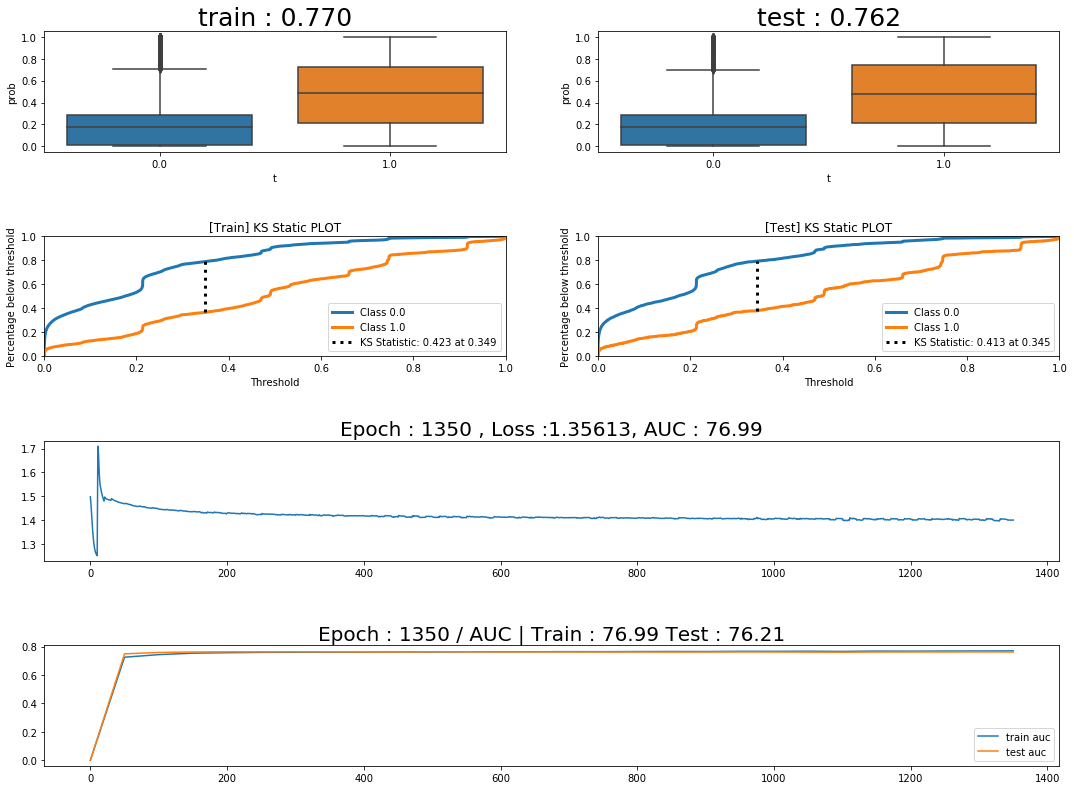

In [ ]:
from sklearn.metrics import confusion_matrix
Epoch = 10000
mb_size = 1000
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
_Loss_ = []
_Epoch_ = []
_Epoch2_ = [0]
_trAUC_ , _teAUC_ = [0] , [0]
print("Train")
for epoch in range(Epoch) :
    print(epoch , end = "\r")
    target1 = np.random.choice(target_1_list ,
                               len(target_1_list) ,
                               replace = False )
    target0 = np.random.choice(target_0_list , 
                               len(target_0_list) ,
                               replace = False )
    target1 = list(target1)
    target0 = list(target0)
    if epoch > 10 :
        target1 = target1 + 2 * checkpoint 
    XX = Train_X_np[target1 + target0  , : ]
    YY = Train_y.values[target1 + target0]
    idx = np.random.permutation(len(XX))
    XX = XX[idx , : ]
    YY = YY[idx]
    batch_iter = int(len(XX) / mb_size)
    batchLoss = 0
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb.reshape(-1,1) , 
                DropoutRate : 1.0 ,
                training : True 
               }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        batchLoss += LOSS
    batchLoss /= batch_iter
    _Loss_.append(batchLoss)
    _Epoch_.append(epoch)
    
    if epoch % 10 == 0 :
        Feed = { X : Train_X_np  ,
                DropoutRate : 1.0,
                training : True 
               }
        probs  = sess.run(Probs , feed_dict= Feed)
        real_target = np.squeeze(Train_y.values)
        pred_target = np.argmax(probs,axis =1)
        AUC = roc_auc_score(real_target , probs[:,1])
        DD = pd.DataFrame([real_target ,pred_target], index = ["t","p"]).T
        DD2 = DD[(DD.t == 1) & (DD.p==0)]
        checkpoint = DD2.index.tolist()
    
    if epoch % 50 == 0 :
        we = sess.run(weights_tree)
        plt.scatter(np.arange(0,len(we)), we)
        plt.savefig(f"./NNEnsembleResult/b/plot.{epoch:05d}.png")
        plt.title(f"Tree Weight : {len(we)} ")
        plt.show()
    msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,LOSS ,AUC*100)
    if (epoch % 50 == 0) & ( epoch > 0 ) :
#         __idx__ = np.random.permutation(len(Train_X_np))
#         __idx__ = np.random.choice(__idx__ , replace = False, size= 500)
#         Feed = { X : Train_X_np[__idx__,:]  ,
#                 DropoutRate : 1 ,
#                 training : True }
        dd = [sess.run( getattr(mod,  "model_{}_softmax".format(i)) , 
                       feed_dict= Feed)  for i in np.arange(len(NModels))]
        s = pd.DataFrame(dd)
        models = np.arange(s.shape[0])
        indexs = np.arange(s.shape[1])
        fig, ax = plt.subplots( figsize = (12,8))
        plt.pcolor(s)
        plt.yticks(np.arange(0.5, len(models), 1),models)
        plt.title(msg)
        plt.savefig(f"./NNEnsembleResult/c/plot.{epoch:05d}.png")
        plt.close()    
        #d = pd.DataFrame(dd).sum(axis = 0)
        #plt.scatter( np.arange(len(d)) , d.values)
    if (epoch % 50 == 0) & ( epoch > 0 ):
        clear_output()
        print(confusion_matrix(real_target , pred_target))
        print(msg)
        print("target 1 oversample n : ", len(checkpoint))
        trainDD = pd.DataFrame([real_target ,probs[:,1]],
                               index = ["t","prob"]).T
        trainAUC = AUC
        Feed = { X : Test_X_np  ,
            DropoutRate : 1.0 ,
            training : True 
           }
        testprobs  = sess.run(Probs , feed_dict= Feed)
        real_target = np.squeeze(Test_y.values)
        pred_target = np.argmax(testprobs,axis =1)
        testAUC = roc_auc_score(real_target , testprobs[:,1])
        testDD = pd.DataFrame([real_target ,testprobs[:,1]],
                          index = ["t","prob"]).T
        ###################################################
        fig , axes = plt.subplots(nrows=4 ,ncols=2,
                  figsize=(15,12) )
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.5)
        ax = axes.flatten()
        sns.boxplot(x="t", y="prob", data=trainDD, ax = ax[0])
        ax[0].set_title("train : {:.3f}".format(trainAUC), fontsize= 25)
        sns.boxplot(x="t", y="prob", data=testDD, ax = ax[1])
        ax[1].set_title("test : {:.3f}".format(testAUC), fontsize= 25)
        skplt.metrics.plot_ks_statistic(Train_y.values, probs , 
                                        ax = ax[2] , 
                                        title = "[Train] KS Static PLOT")
        skplt.metrics.plot_ks_statistic(Test_y.values, testprobs ,
                                        ax = ax[3], 
                                        title = "[Test] KS Static PLOT")

        ax3 = plt.subplot(413)
        plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, 
                            top=0.95, wspace=None, hspace=0.7)
        ax3.plot(_Epoch_ , _Loss_ )
        ax3.set_title(msg, fontsize= 20)
        _Epoch2_.append(epoch)
        _trAUC_.append(trainAUC)
        _teAUC_.append(testAUC)
        ax4 = plt.subplot(414)
        ax4.plot(_Epoch2_ , _trAUC_ , label = "train auc")
        ax4.plot(_Epoch2_ , _teAUC_ , label = "test auc")
        ax4.legend()
        msg = "Epoch : {} / AUC | Train : {:.2f} Test : {:.2f}".format(epoch , 
                                                               100*trainAUC ,
                                                               100*testAUC
                                                              )
        ax4.set_title(msg, fontsize= 20)
        plt.savefig(f"./NNEnsembleResult/d/plot.{epoch:05d}.png")
        plt.show()